In [4]:
# In this notebook we examine the vertical structure of different convective cores
# We stratify by the morphology
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.radar import *
from src.pf_stats import *
from src.regions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Load data
CORE_THRESH = 10
regions = [
    cio_region(), 
    wmp_region()
]

radar = xr.concat(
    [load_merged_radar(r) for r in regions], 
    dim='features'
)

pf_stats = pd.concat(
    [load_pf_stats(r, just_tropics=False) for r in regions]
)

In [63]:
exps_id = (pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_max_precip_8conn'] > 80)
exps_radar = radar[f'rainiest_{CORE_THRESH}mmhr_cluster_refl_conn8'].isel(features=exps_id)
exps_core_size = pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_size_8conn'][exps_id]

# Bin over sizes, compute mean profile
size_bins = np.arange(1, 50, 5)
n_bins = len(size_bins) - 1
bin_indices = np.digitize(exps_core_size, size_bins) - 1


mean_profiles = np.full((n_bins, exps_radar.shape[1]), np.nan)
for i in range(n_bins): 
    # Create a mask for features in the current bin
    mask = (bin_indices == i)
    if np.sum(mask)>=5:
        # Mean over features, retaining the z-dimension
        mean_profiles[i, :] = np.nanmean(exps_radar[mask, :], axis=0)

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_83134/1897217087.py:17: RuntimeWarning: Mean of empty slice
  mean_profiles[i, :] = np.nanmean(exps_radar[mask, :], axis=0)


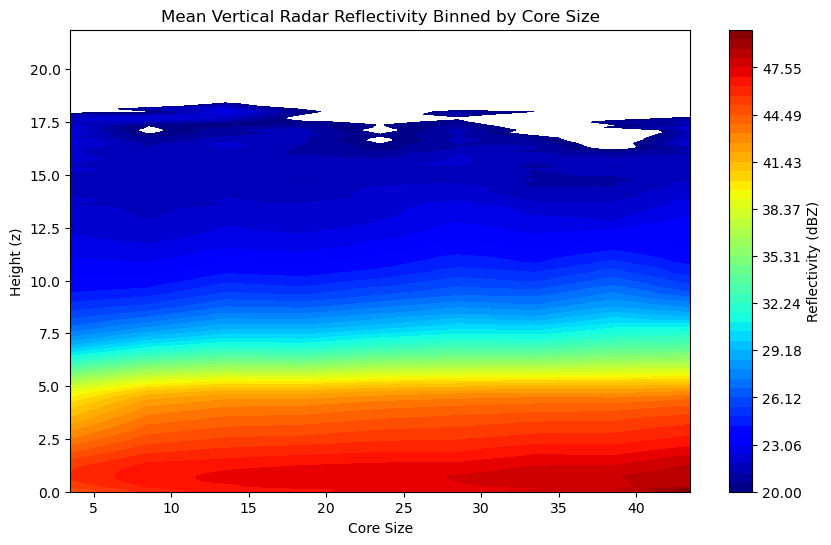

In [64]:

# Compute the centers of the size bins for plotting on the x-axis.
bin_centers = (size_bins[:-1] + size_bins[1:]) / 2.
z = exps_radar.alt
# Create a meshgrid for contour plotting: x-axis = core size, y-axis = z
X, Y = np.meshgrid(bin_centers, z)

# Plot the contour plot of the mean reflectivity profiles
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, np.log10(mean_profiles.T)*10,
                       levels=np.linspace(20, 50), cmap='jet')
plt.xlabel('Core Size')
plt.ylabel('Height (z)')
plt.title('Mean Vertical Radar Reflectivity Binned by Core Size')
plt.colorbar(contour, label='Reflectivity (dBZ)')
plt.show()
